Processing volunteer 2/11: An50dB.mat...
Processing volunteer 3/11: Bb50dB.mat...
Processing volunteer 4/11: Er50dB.mat...
Processing volunteer 5/11: Lu50dB.mat...
Processing volunteer 6/11: So50dB.mat...
Processing volunteer 7/11: Qu50dB.mat...
Processing volunteer 8/11: Vi50dB.mat...
Processing volunteer 9/11: Sa50dB.mat...
Processing volunteer 10/11: Ti50dB.mat...
Processing volunteer 11/11: Wr50dB.mat...

Processing complete. Starting analysis and plotting...


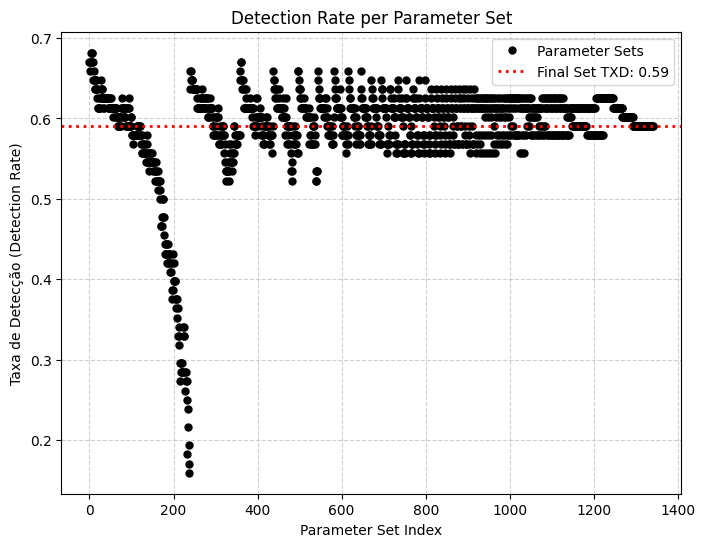

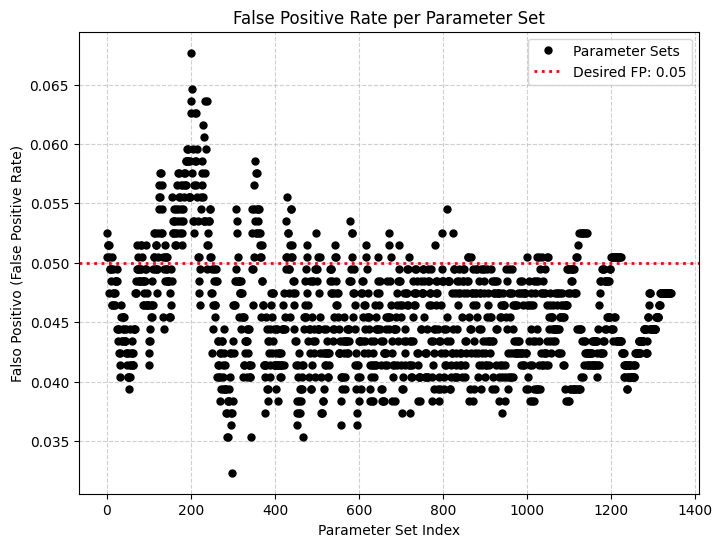


--- Pareto Front Optimal Parameters ---
PD = 59.09% | Time = 175.26s | Configurations: Buffer:10, M_step:1
PD = 60.23% | Time = 177.63s | Configurations: Buffer:51, M_step:1
PD = 61.36% | Time = 183.08s | Configurations: Buffer:76, M_step:1
PD = 62.50% | Time = 187.68s | Configurations: Buffer:92, M_step:2
PD = 63.64% | Time = 206.00s | Configurations: Buffer:128, M_step:16
PD = 64.77% | Time = 233.01s | Configurations: Buffer:223, M_step:1
PD = 65.91% | Time = 236.16s | Configurations: Buffer:230, M_step:2 | Buffer:231, M_step:1
PD = 65.91% | Time = 236.16s | Configurations: Buffer:230, M_step:2 | Buffer:231, M_step:1
PD = 67.05% | Time = 237.45s | Configurations: Buffer:228, M_step:4
PD = 68.18% | Time = 240.00s | Configurations: Buffer:236, M_step:4 | Buffer:234, M_step:6 | Buffer:233, M_step:7
PD = 68.18% | Time = 240.00s | Configurations: Buffer:236, M_step:4 | Buffer:234, M_step:6 | Buffer:233, M_step:7
PD = 68.18% | Time = 240.00s | Configurations: Buffer:236, M_step:4 | Buffer

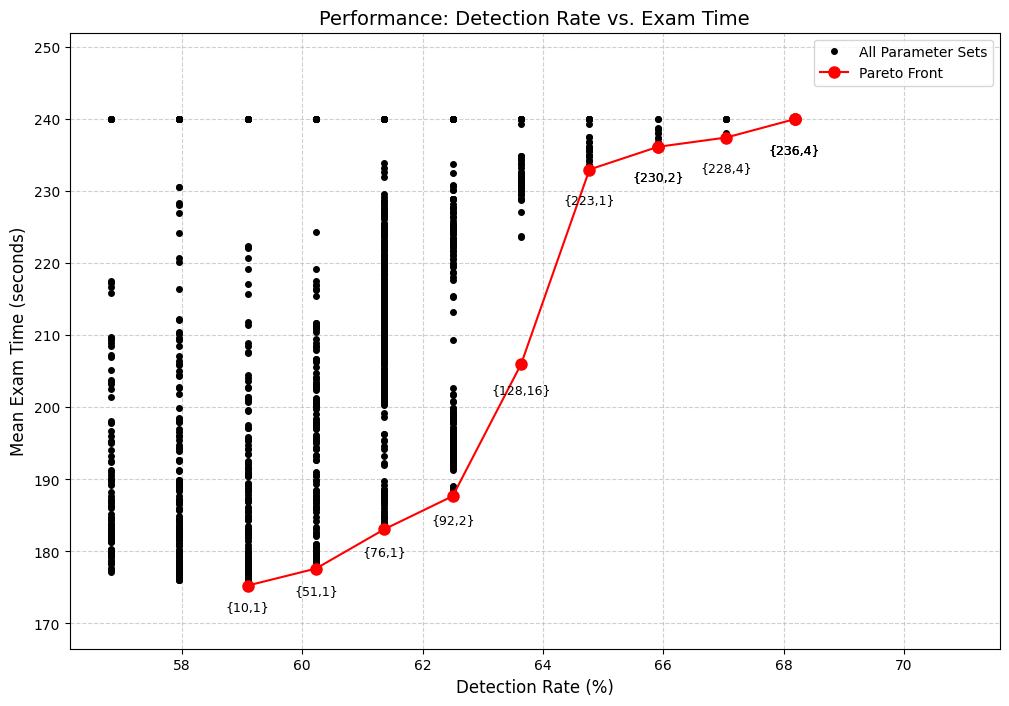

In [1]:
# =============================================================================
# Section 1: Imports and Configuration
# =============================================================================
import os
import numpy as np
import matplotlib.pyplot as plt
# You must install this library first by running: pip install mat73
import mat73

# --- User-editable paths ---
# Path to the directory containing the 'NDC_AlfaCorrigido_*.mat' file
path_mat_file = r"C:\PPGEE\Assessing CGST on ASSR\Numero_Deteccoes_consecutiva_H"

# Path to the directory containing the EEG data (.mat files for each volunteer)
path_eeg_data = r"C:\Users\alexa\experimental_data\todos\ENTRADAS_PATRICIA"


# =============================================================================
# Section 2: Function Definitions (Replication of .m files)
# =============================================================================

def VC_MSC_py(M, alfa):
    """
    Calculates the theoretical critical value for the Magnitude-Squared Coherence (MSC).
    Equivalent to VC_MSC.m
    """
    M_safe = np.asarray(M, dtype=float)
    invalid_mask = M_safe <= 1
    M_safe[invalid_mask] = np.nan
    vc_teorico = 1 - np.power(alfa, 1. / (M_safe - 1))
    return vc_teorico

def msc_fft_py(Y):
    """
    Calculates the Magnitude-Squared Coherence (MSC) from FFT data.
    Equivalent to msc_fft.m
    """
    M = Y.shape[1]
    if M == 0:
        return np.full((Y.shape[0],), np.nan)
    numerator = np.abs(np.sum(Y, axis=1))**2
    denominator = M * np.sum(np.abs(Y)**2, axis=1)
    ord_val = np.zeros_like(numerator, dtype=float)
    non_zero_den_mask = denominator != 0
    ord_val[non_zero_den_mask] = numerator[non_zero_den_mask] / denominator[non_zero_den_mask]
    return ord_val

def ETS_py(ord_values, MM, alfa, NDC):
    """
    Implements the Early Termination Strategy for sequential tests.
    Equivalent to ETS.m
    """
    NDC = np.ceil(NDC)
    valor_critico = VC_MSC_py(MM, alfa)
    det = ord_values[MM - 2] > valor_critico
    consecutive_detections = 0
    detection_made = 0
    detection_time = MM[-1]
    for i, is_detected in enumerate(det):
        if is_detected:
            consecutive_detections += 1
        else:
            consecutive_detections = 0
        if consecutive_detections >= NDC:
            detection_made = 1
            detection_time = MM[i]
            break
    return detection_made, detection_time

def protocolo_deteccao_py(x, parametros):
    """
    Applies the detection protocol to input data 'x'.
    Equivalent to protocolo_deteccao.m
    """
    binsM_protocol = 120
    num_windows_total = x.shape[1]
    xfft = np.fft.fft(x, axis=0)
    ord_matrix = np.zeros((binsM_protocol, num_windows_total - 1))
    for M in range(2, num_windows_total + 1):
        xfft_slice = xfft[:binsM_protocol, :M]
        ord_matrix[:, M - 2] = msc_fft_py(xfft_slice)
    num_param_sets = parametros.shape[0]
    dr_results = np.zeros((binsM_protocol, num_param_sets))
    time_results = np.zeros((binsM_protocol, num_param_sets))
    for ii in range(num_param_sets):
        Mmin, Mstep, Mmax, NDC, alfa_corr = parametros[ii, :]
        MM = np.arange(Mmin, Mmax + 1, Mstep, dtype=int)
        if MM.size == 0: continue
        for ll in range(binsM_protocol):
            dr, time = ETS_py(ord_matrix[ll, :], MM, alfa_corr, NDC)
            dr_results[ll, ii] = dr
            time_results[ll, ii] = time
    return dr_results, time_results

def pareto_front_py(points):
    """
    Finds the Pareto front for a set of points.
    Assumes maximization of both objectives.
    """
    n_points = points.shape[0]
    is_pareto = np.ones(n_points, dtype=bool)
    for i in range(n_points):
        for j in range(n_points):
            if i == j: continue
            if np.all(points[j] >= points[i]) and np.any(points[j] > points[i]):
                is_pareto[i] = False
                break
    return points[is_pareto], np.where(is_pareto)[0]


# =============================================================================
# Section 3: Main Script (Replication of sinal_eeg.m)
# =============================================================================

# --- Script Parameters ---
Vvoluntario = ['Ab', 'An', 'Bb', 'Er', 'Lu', 'So', 'Qu', 'Vi', 'Sa', 'Ti', 'Wr']
Intensidade = ['50dB']
Mmax = 240
alfa = 0.05
FP_desejado = 0.05
pos_ele = 1
ganho = 200
remoc = 0.1 / ganho

# --- Load Protocol Parameters ---
mat_filename = f"NDC_AlfaCorrigido_Mmax{Mmax}_alfa_{alfa}_FPdesejado{FP_desejado}.mat"
mat_filepath = os.path.join(path_mat_file, mat_filename)

try:
    print(f"Loading parameters from: {mat_filepath}")
    mat_contents = mat73.loadmat(mat_filepath)
    P = mat_contents['P']
    alfa_corrigido = mat_contents['alfa_corrigido']
    NDC_minimo = mat_contents['NDC_minimo']
except FileNotFoundError:
    print(f"FATAL ERROR: Could not find the parameter file:\n{mat_filepath}")
    exit()
except KeyError as e:
    print(f"FATAL ERROR: The .mat file is missing an expected variable: {e}")
    exit()

# --- Assemble Parameters Matrix ---
parametros = np.hstack((P, np.array(NDC_minimo).reshape(-1, 1), np.array(alfa_corrigido).reshape(-1, 1)))

# --- Initialize Result Storage Arrays ---
num_bins_protocol = 120
num_params = parametros.shape[0]
num_volunteers = len(Vvoluntario)
Tdr = np.zeros((num_bins_protocol, num_params, num_volunteers))
Ttime = np.zeros((num_bins_protocol, num_params, num_volunteers))

# --- Main Loop over Volunteers ---
for cont_vol, voluntario_code in enumerate(Vvoluntario):
    intensidade = Intensidade[0]
    eeg_filename = f"{voluntario_code}{intensidade}.mat"
    eeg_filepath = os.path.join(path_eeg_data, eeg_filename)
    
    print(f"Processing volunteer {cont_vol + 1}/{num_volunteers}: {eeg_filename}...")
    
    eeg_data = mat73.loadmat(eeg_filepath)
    x = eeg_data['x']
    Fs = float(eeg_data['Fs'])
    
    # MODIFIED: Convert the indexing array to an integer type to prevent IndexError.
    binsM_analysis = (np.array(eeg_data['binsM']).flatten() - 1).astype(int)

    # --- Preprocessing ---
    x = x[:, :, pos_ele - 1]
    x = x - x.mean(axis=0, keepdims=True)
    x = x[:, 2:]
    Vmax = np.max(np.abs(x), axis=0)
    clean_indices = Vmax <= remoc
    x = x[:, clean_indices]
    x = x[:, :Mmax]
     
    if x.shape[1] < 2:
        print(f"  -> Skipping volunteer {voluntario_code} due to insufficient clean data (<2 windows).")
        continue
        
    dr, time = protocolo_deteccao_py(x, parametros)
    Tdr[:, :, cont_vol] = dr
    Ttime[:, :, cont_vol] = time

print("\nProcessing complete. Starting analysis and plotting...")

# =============================================================================
# Section 4: Analysis and Plotting
# =============================================================================

# --- Calculate TXD (Detection Rate) and FP (False Positive) ---
# This line will now work correctly with the integer-type `binsM_analysis`
TXD = np.mean(np.mean(Tdr[binsM_analysis, :, :], axis=2), axis=0)
all_bins = np.arange(100)
binsR = np.setdiff1d(all_bins, binsM_analysis)
binsR = binsR[binsR > 1] 
FP = np.mean(np.mean(Tdr[binsR, :, :], axis=2), axis=0)

# --- Plot 1: Detection Rate ---
plt.figure(figsize=(8, 6))
plt.plot(TXD, '.k', markersize=10, label='Parameter Sets')
plt.axhline(y=TXD[-1], color='r', linestyle=':', linewidth=2, label=f'Final Set TXD: {TXD[-1]:.2f}')
plt.ylabel('Taxa de Detecção (Detection Rate)')
plt.xlabel('Parameter Set Index')
plt.title('Detection Rate per Parameter Set')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Plot 2: False Positive Rate ---
plt.figure(figsize=(8, 6))
plt.plot(FP, '.k', markersize=10, label='Parameter Sets')
plt.axhline(y=FP_desejado, color='r', linestyle=':', linewidth=2, label=f'Desired FP: {FP_desejado:.2f}')
plt.ylabel('Falso Positivo (False Positive Rate)')
plt.xlabel('Parameter Set Index')
plt.title('False Positive Rate per Parameter Set')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Plot 3: Pareto Front (Detection Rate vs. Time) ---
timeM = Ttime[binsM_analysis, :, :]
timeM[timeM == -1] = Mmax
timeM_mean = np.mean(np.mean(timeM, axis=2), axis=0)
TXD_percent = TXD * 100

fig1, axes1 = plt.subplots(figsize=(12, 8))
axes1.plot(TXD_percent, timeM_mean, '.k', markersize=8, label='All Parameter Sets')

points_for_pareto = np.vstack((TXD_percent, -timeM_mean)).T
p_front_points, p_front_indices = pareto_front_py(points_for_pareto)

sort_order = np.argsort(p_front_points[:, 0])
p_front_points = p_front_points[sort_order]
p_front_indices = p_front_indices[sort_order]

axes1.plot(p_front_points[:, 0], -p_front_points[:, 1], '-or', 
           markersize=8, linewidth=1.5, label='Pareto Front')

axes1.set_xlabel('Detection Rate (%)', fontsize=12)
axes1.set_ylabel('Mean Exam Time (seconds)', fontsize=12)
axes1.set_title('Performance: Detection Rate vs. Exam Time', fontsize=14)
axes1.grid(True, linestyle='--', alpha=0.6)
axes1.legend()

print('\n--- Pareto Front Optimal Parameters ---')
for idx in p_front_indices:
    pd_val = TXD_percent[idx]
    time_val = timeM_mean[idx]
    matches = np.where((np.isclose(TXD_percent, pd_val)) & (np.isclose(timeM_mean, time_val)))[0]
    param_str = ' | '.join([f"Buffer:{int(parametros[m,0])}, M_step:{int(parametros[m,1])}" for m in matches])
    print(f'PD = {pd_val:.2f}% | Time = {time_val:.2f}s | Configurations: {param_str}')
    text_str = f"{{{int(parametros[matches[0], 0])},{int(parametros[matches[0], 1])}}}"
    axes1.text(pd_val, time_val * 0.98, text_str, fontsize=9, ha='center')

if len(p_front_points) > 0:
    axes1.set_xlim([np.min(p_front_points[:, 0]) * 0.95, np.max(p_front_points[:, 0]) * 1.05])
    axes1.set_ylim([np.min(-p_front_points[:, 1]) * 0.95, Mmax * 1.05])

plt.show()